In [1]:
# Import experimental feature first
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from mrmr import mrmr_classif

# Re-run the rest of the code now that IterativeImputer is properly enabled
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, GenericUnivariateSelect, VarianceThreshold
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, accuracy_score, recall_score,
    precision_score, f1_score, confusion_matrix,
    roc_curve, auc, ConfusionMatrixDisplay,
    average_precision_score
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import os
import optuna
from scipy.stats import gaussian_kde

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from tqdm import tqdm

import pymysql.cursors
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from IPython.display import clear_output
from sklearn.utils import resample

from connections import *
import pickle

# REMOVE REDUNDANT FEATURES 

In [4]:
# ==== 1) Create 5 random probes ====
def add_random_probes(X: pd.DataFrame, n_probes: int = 5, seed: int = 42) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    X_aug = X.copy()
    for i in range(n_probes):
        X_aug[f"rand_probe_{i+1}"] = rng.normal(loc=0.0, scale=1.0, size=len(X_aug))
    return X_aug

# ==== 2) Iterative Imputer ====
def minimal_preprocess(X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
    """
    Solo imputación iterativa sobre todas las columnas (asumidas numéricas).
    Devuelve un DataFrame numérico sin NaNs, listo para VT + mRMR.
    """
    imputer = IterativeImputer(max_iter=1000, random_state=42)
    X_imputed = imputer.fit_transform(X, y)
    return pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

# ==== 3) Variance Threshold ====
def apply_variance_threshold(X_num: pd.DataFrame, threshold: float = 0.01) -> pd.DataFrame:
    vt = VarianceThreshold(threshold=threshold)
    Xt = vt.fit_transform(X_num.values)
    kept_mask = vt.get_support()
    kept_cols = X_num.columns[kept_mask]
    return pd.DataFrame(Xt, columns=kept_cols, index=X_num.index)

# ==== 4) mRMR ranking ====
def run_mrmr_ranking(X_num: pd.DataFrame, y: pd.Series, K: int | None = None) -> list[str]:
    """
    mrmr_classif devuelve lista de nombres ordenados (mejor → peor).
    Asegúrate de pasar DataFrame numérico sin NaNs.
    """
    if K is None:
        K = X_num.shape[1]
    return mrmr_classif(X=X_num, y=y, K=K)

# ==== 5) Filter agains probes ====
def filter_below_random_probes(ranking: list[str], probe_prefix: str = "rand_probe_") -> list[str]:
    """
    Mantiene solo las variables con ranking mejor que la peor random probe.
    Si no hay probes (o no están en el ranking), no filtra nada.
    """
    probe_positions = [i for i, f in enumerate(ranking) if f.startswith(probe_prefix)]
    if not probe_positions:
        return ranking  # no probes presentes
    worst_probe_pos = max(probe_positions)  # índice más alto = peor entre las probes
    return [f for i, f in enumerate(ranking) if i < worst_probe_pos and not f.startswith(probe_prefix)]

# ==== 6) Pipeline end-to-end ====
def feature_reduction_workflow(X_raw: pd.DataFrame, y: pd.Series,
                               n_probes: int = 5,
                               vt_threshold: float = 0.01,
                               seed: int = 42) -> dict:
    """
    Devuelve:
      - X_final: DataFrame reducido tras VT + mRMR + filtro contra probes
      - ranking_all: ranking mRMR completo (incluyendo probes)
      - kept_features: lista final de columnas mantenidas (sin probes)
      - removed_by_vt: variables reales eliminadas por Variance Threshold
      - removed_by_mrmr: variables reales eliminadas por el filtro mRMR (tras VT)
      - removed_probes_by_vt: probes eliminadas por VT
      - removed_probes_by_mrmr: probes eliminadas por el filtro mRMR (tras VT)
      - vt_kept_features: columnas que sobrevivieron a VT (incluye probes si sobrevivieron)
    """
    # Helper
    def is_probe(name: str) -> bool:
        return str(name).startswith("rand_probe_")

    # 1) Add probes
    X_aug = add_random_probes(X_raw, n_probes=n_probes, seed=seed)

    # 2) Imputation
    X_pp = minimal_preprocess(X_aug, y)
    pp_cols = list(X_pp.columns)

    # 3) Variance Threshold
    X_vt = apply_variance_threshold(X_pp, threshold=vt_threshold)
    vt_kept_features = list(X_vt.columns)

    # --- Removed by VT ---
    removed_by_vt_all = [c for c in pp_cols if c not in vt_kept_features]
    removed_by_vt = [c for c in removed_by_vt_all if not is_probe(c)]
    removed_probes_by_vt = [c for c in removed_by_vt_all if is_probe(c)]

    # 4) mRMR
    ranking_all = run_mrmr_ranking(X_vt, y, K=X_vt.shape[1])

    # 5) Filter by random probes (we keep the features ranked better thant the worst probe)
    kept_features_with_probes = filter_below_random_probes(ranking_all, probe_prefix="rand_probe_")

    # 6) Final features without probes
    kept_features = [f for f in kept_features_with_probes if not is_probe(f)]
    X_final = X_vt[kept_features].copy()

    # --- Removed by mRMR---
    removed_by_mrmr_all = [c for c in vt_kept_features if c not in kept_features]
    removed_by_mrmr = [c for c in removed_by_mrmr_all if not is_probe(c)]
    removed_probes_by_mrmr = [c for c in removed_by_mrmr_all if is_probe(c)]

    return {
        "X_final": X_final,
        "ranking_all": ranking_all,
        "kept_features": kept_features,
        "removed_by_vt": removed_by_vt,
        "removed_by_mrmr": removed_by_mrmr,
        "removed_probes_by_vt": removed_probes_by_vt,
        "removed_probes_by_mrmr": removed_probes_by_mrmr,
        "vt_kept_features": vt_kept_features,
    }

# ==== 7) Run the pipeline for -24h, -48h and -72h windows ====
def run_by_window(df: pd.DataFrame,
                  n_probes: int = 5, vt_threshold: float = 0.01) -> dict:

    df_hr = df[df["hr"].isin([-1, -24, -48])].drop(columns=["PatientID", "hr"], errors="ignore")
        
    y = df_hr["NAV"].astype(int)
    X = df_hr.drop(columns=["NAV"], errors="ignore")
    return feature_reduction_workflow(X, y, n_probes=n_probes, vt_threshold=vt_threshold)

In [5]:
# ========== LOAD AND DATA PROCESSING ==========
df = pd.read_pickle("data/extraction/nav_processed_v2.pkl")
no_significativas = [
    
    # variables with more than 30% missings
    "pct_median", "pct_min", "pct_max",

    # non-significant categorical variables in 24h prior the event
    "AdmType_scheduled", "AdmType_urgent",
    "MPOC",
    "dias_VMI",
    "ICU_days",
    "exitus",
    "consistencia_secreciones_altres", "consistencia_secreciones_espesses", "consistencia_secreciones_fluides", "consistencia_secreciones_taps_de_moc",
    "reintubacion"
]
df.drop(columns=no_significativas, inplace=True)

In [6]:
res = run_by_window(df, n_probes = 10)

100%|██████████| 75/75 [00:05<00:00, 13.00it/s]


In [7]:
lista_features = res['kept_features']

In [8]:
print(f"=== Removed by Variance Threshold ===")
print(len(res["removed_by_vt"]))
print(res["removed_by_vt"])

print(f"\n=== Removed by mRMR ===")
print(len(res["removed_by_mrmr"]))
print(res["removed_by_mrmr"])

print(f"\n=== Nº of original features ===")
print(df.drop(['PatientID', 'hr', 'NAV'], axis=1).shape[1])

print(f"\n=== Nº of remaining features ===")
print(len(lista_features))

=== Removed by Variance Threshold ===
3
['ph_median', 'ph_min', 'ph_max']

=== Removed by mRMR ===
0
[]

=== Nº of original features ===
68

=== Nº of remaining features ===
65


# SELECT BEST MODEL + BEST FEATURE SELECTOR

## PIPELINE

In [9]:
import numpy as np
import random
import os

np.random.seed(42)
random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

In [23]:
# Define models and selectors
models = {
    'XGBoost': XGBClassifier(eval_metric='auc', random_state=42),
    'LightGBM': LGBMClassifier(verbose=-1, random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
}

selectors = {
    'mRMR': lambda k: 'mRMR',
    'SelectKBest_f': lambda k: SelectKBest(score_func=f_classif, k=k),
    'SelectKBest_MI': lambda k: SelectKBest(score_func=mutual_info_classif, k=k),
    'GenericUnivariateSelect': lambda k: GenericUnivariateSelect(score_func=f_classif, mode='k_best', param=k),
    'VarianceThreshold': lambda k: VarianceThreshold(threshold=0.01),
    'ModelBased_XGB': lambda k: 'ModelBased_XGB',
    'ModelBased_LGBM': lambda k: 'ModelBased_LGBM',
    'ModelBased_RF': lambda k: 'ModelBased_RF',
    'ModelBased_CatBoost': lambda k: 'ModelBased_CatBoost',
    'ModelBased_ExtraTrees': lambda k: 'ModelBased_ExtraTrees',
}

# Feature ranking function
def get_ranked_features(X, y, method):
    if method == "SelectKBest_f":
        selector = SelectKBest(score_func=f_classif, k='all')
        selector.fit(X, y)
        scores = selector.scores_
        return list(X.columns[np.argsort(scores)[::-1]])
    elif method == "SelectKBest_MI":
        selector = SelectKBest(score_func=mutual_info_classif, k='all')
        selector.fit(X, y)
        scores = selector.scores_
        return list(X.columns[np.argsort(scores)[::-1]])
    elif method == "GenericUnivariateSelect":
        selector = GenericUnivariateSelect(score_func=f_classif, mode='k_best', param='all')
        selector.fit(X, y)
        scores = selector.scores_
        return list(X.columns[np.argsort(scores)[::-1]])
    elif method == "VarianceThreshold":
        variances = X.var()
        return list(X.columns[np.argsort(variances.values)[::-1]])
    elif method == "ModelBased_XGB":
        model = XGBClassifier(eval_metric='logloss', random_state=42, verbosity=0)
        model.fit(X, y)
        importances = model.feature_importances_
        return list(X.columns[np.argsort(importances)[::-1]])
    elif method == "ModelBased_LGBM":
        model = LGBMClassifier(random_state=42, verbose=-1)
        model.fit(X, y)
        importances = model.booster_.feature_importance(importance_type='gain')
        return list(X.columns[np.argsort(importances)[::-1]])
    elif method == "ModelBased_RF":
        model = RandomForestClassifier(random_state=42, verbose=0)
        model.fit(X, y)
        importances = model.feature_importances_
        return list(X.columns[np.argsort(importances)[::-1]])
    elif method == "ModelBased_CatBoost":
        model = CatBoostClassifier(random_state=42, verbose=0)
        model.fit(X, y)
        importances = model.get_feature_importance()
        return list(X.columns[np.argsort(importances)[::-1]])
    elif method == "ModelBased_ExtraTrees":
        model = ExtraTreesClassifier(random_state=42, verbose=0)
        model.fit(X, y)
        importances = model.feature_importances_
        return list(X.columns[np.argsort(importances)[::-1]])
    elif method == "mRMR":
        return mrmr_classif(X, y, K=X.shape[1])
    else:
        raise ValueError(f"Método de selección desconocido: {method}")

# Experiment runner with multiple metrics
def run_experiment(df, hr_list, selector_names, cv=False):
    results = {}

    for hr in hr_list:
        df_hr = df[df['hr'] == hr]        
        df_hr = df_hr.drop(columns=['PatientID', 'hr'], axis=1).reset_index(drop=True)
        
        X = df_hr.drop(columns=['NAV'], axis=1)
        y = df_hr['NAV']
        columns = list(X.columns)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        imputer = IterativeImputer(max_iter=1000, random_state=42)
        X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
        X_test = pd.DataFrame(imputer.transform(X_test), columns=X.columns)
        # X_test_24 = pd.DataFrame(imputer.transform(X_test_24), columns=X.columns)

        X_train, y_train = downsampling(X_train.values, y_train, majority_proportion=1.0)
        X_train = pd.DataFrame(X_train, columns=columns)

        results[f'hr={hr}'] = {}

        for selector_name in selector_names:
            ranked_features = get_ranked_features(X_train, y_train, selector_name)
            results[f'hr={hr}'][selector_name] = {model: defaultdict(list) for model in models}

            for k in tqdm(range(1, len(ranked_features) + 1), desc=f"[hr={hr}] {selector_name}"):
                selected_features = ranked_features[:k]

                for model_name, model in models.items():
                    try:
                        X_train_selected = X_train[selected_features]
                        X_test_selected = X_test[selected_features]
                        
                        if model_name in ["MLP", "LogisticRegression"]:
                            scaler = MinMaxScaler()
                            X_train_selected = scaler.fit_transform(X_train_selected)
                            X_test_selected = scaler.transform(X_test_selected)
                        
                        model.fit(X_train_selected, y_train)
                        y_pred = model.predict(X_test_selected)
                        y_pred_prob = model.predict_proba(X_test_selected)[:, 1]

                        results[f'hr={hr}'][selector_name][model_name]['AUC'].append(roc_auc_score(y_test, y_pred_prob))
                        results[f'hr={hr}'][selector_name][model_name]['PR_AUC'].append(average_precision_score(y_test, y_pred_prob))
                        results[f'hr={hr}'][selector_name][model_name]['Accuracy'].append(accuracy_score(y_test, y_pred))
                        results[f'hr={hr}'][selector_name][model_name]['Recall'].append(recall_score(y_test, y_pred))
                        results[f'hr={hr}'][selector_name][model_name]['Precision'].append(precision_score(y_test, y_pred))
                        results[f'hr={hr}'][selector_name][model_name]['F1'].append(f1_score(y_test, y_pred))
                    except Exception:
                        for metric in ['AUC', 'PR_AUC', 'Accuracy', 'Recall', 'Precision', 'F1']:
                            results[f'hr={hr}'][selector_name][model_name][metric].append(np.nan)
    return results, ranked_features

    
def downsampling(X_train, y_train, majority_proportion=1.0):
    """
    Performs downsampling on the majority class to balance the dataset.
    
    Parameters:
    X_train (array-like): Feature matrix of the training data.
    y_train (array-like): Label array corresponding to the training data.
    majority_proportion (float or None): 
        - If float, ratio of majority class to minority class (e.g. 1.0 means balanced).
        - If None, no downsampling is performed.

    Returns:
    tuple: Downsampled (or original) feature matrix and label array as numpy arrays.
    """
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)

    if majority_proportion is None:
        return X_train, y_train

    # Separate minority and majority class samples
    X_minority = X_train[y_train == 1]
    X_majority = X_train[y_train != 1]
    y_majority = y_train[y_train != 1]

    # Calculate number of majority class samples to keep
    desired_majority_samples = int(len(X_minority) * majority_proportion)

    # Downsample majority class
    X_majority_downsampled, y_majority_downsampled = resample(
        X_majority, y_majority,
        replace=False,
        n_samples=desired_majority_samples,
        random_state=42
    )

    # Combine minority and downsampled majority
    X_balanced = np.vstack((X_minority, X_majority_downsampled))
    y_balanced = np.hstack((np.ones(len(X_minority)), y_majority_downsampled))

    return X_balanced, y_balanced

## PLOTS

In [24]:
# Plotting summary of metrics
def get_text_color(rgb_color):
    """Calcula la luminancia para decidir si el texto debe ser blanco o negro."""
    r, g, b = rgb_color[:3]
    luminancia = 0.2126 * r + 0.7152 * g + 0.0722 * b
    return 'black' if luminancia > 0.6 else 'white'

def analizar_resultados_metricas(results_all_hrs, metricas=['AUC', 'PR_AUC', 'Accuracy', 'Recall', 'Precision', 'F1'], top=5):
    num_metricas = len(metricas)
    fig, axes = plt.subplots(num_metricas, 1, figsize=(13, 5 * num_metricas), layout='constrained')

    if num_metricas == 1:
        axes = [axes]

    for i, metric in enumerate(metricas):
        metric_dict_model = {}

        for model in models.keys():
            metric_scores = []
            for selector in selectors.keys():
                for hr in results_all_hrs.keys():
                    try:
                        values = results_all_hrs[hr][hr][selector][model][metric]
                        metric_scores.extend(sorted(values, reverse=True)[:top])
                    except KeyError:
                        continue
            metric_dict_model[model] = (np.nanmean(metric_scores), np.nanstd(metric_scores))

        df_metric = pd.DataFrame(
            [(model, val[0], val[1]) for model, val in metric_dict_model.items()],
            columns=['model', metric.lower(), 'std']
        ).sort_values(by=metric.lower(), ascending=False)

        # Normalizar entre 0 y 1 para color
        norm = colors.Normalize(vmin=0, vmax=1)
        cmap = cm.get_cmap('Blues')
        bar_colors = [cmap(norm(val)) for val in df_metric[metric.lower()]]

        # Gráfico de barras
        ax = axes[i]
        bars = ax.bar(df_metric["model"], df_metric[metric.lower()], yerr=df_metric["std"],
                      capsize=5, color=bar_colors, edgecolor="black", zorder=3)

        # Título y etiquetas
        ax.set_title(f"{metric} Mean ± Std Dev per Model", fontsize=14, fontweight='bold')
        ax.set_xlabel("Model", fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.set_ylim(0, 1)
        ax.tick_params(axis='x', rotation=45)

        # Grid
        ax.set_axisbelow(True)
        ax.grid(True, linestyle='--', linewidth=0.5, axis='y', alpha=0.7)

        # Anotaciones dentro de las barras
        for bar, val, std, color in zip(bars, df_metric[metric.lower()], df_metric["std"], bar_colors):
            height = bar.get_height()
            center_x = bar.get_x() + bar.get_width() / 2.
            text_color = get_text_color(color)

            mid = height * 0.5
            offset = 0.04  # ajuste vertical fijo en coordenadas del eje Y (puedes probar con 0.03 o 0.05)
            
            if not np.isnan(val) and not np.isnan(std):
                ax.text(center_x, mid, f"{val:.3f}", ha='center', va='center', fontsize=9, color=text_color)
                ax.text(center_x, mid - offset, "±", ha='center', va='center', fontsize=9, color=text_color)
                ax.text(center_x, mid - 2 * offset, f"{std:.2f}", ha='center', va='center', fontsize=9, color=text_color)

        # Colorbar con escala fija de 0 a 1
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
        cbar.set_label(f"{metric} Value", fontsize=11)
        cbar.ax.tick_params(labelsize=9)

    plt.show()

def heatmaps_por_hr(results_all_hrs, metricas=['AUC', 'PR_AUC', 'Accuracy', 'Recall', 'Precision', 'F1'], top=5):
    for i, hr in enumerate(results_all_hrs.keys()):
        data_mean = {}
        data_std = {}

        for model in models.keys():
            data_mean[model] = []
            data_std[model] = []
            for metric in metricas:
                metric_scores = []
                for selector in selectors.keys():
                    try:
                        values = results_all_hrs[hr][hr][selector][model][metric]
                        metric_scores.extend(sorted(values, reverse=True)[:top])
                    except KeyError:
                        continue
                data_mean[model].append(np.nanmean(metric_scores))
                data_std[model].append(np.nanstd(metric_scores))

        # Crear DataFrames de medias y desviaciones estándar
        df_mean = pd.DataFrame(data_mean, index=metricas).T
        df_std = pd.DataFrame(data_std, index=metricas).T

        # Añadir columna 'Mean' como la media de todas las métricas
        df_mean['Mean'] = df_mean[metricas].mean(axis=1)
        df_std['Mean'] = df_std[metricas].mean(axis=1)

        # Ordenar por 'Mean'
        df_mean = df_mean.sort_values(by='Mean', ascending=False)
        df_std = df_std.loc[df_mean.index]

        # Crear anotaciones
        annot = df_mean.copy().astype(str)
        for model in df_mean.index:
            for metric in df_mean.columns:
                mean_val = df_mean.loc[model, metric]
                std_val = df_std.loc[model, metric]
                if np.isfinite(mean_val) and np.isfinite(std_val):
                    annot.loc[model, metric] = f"{mean_val:.3f} ±{std_val:.2f}"
                else:
                    annot.loc[model, metric] = ""

        # Aquí creamos un plot por cada hr
        fig, ax = plt.subplots(figsize=(12, 5))
        sns.heatmap(
            df_mean, annot=annot, fmt="", cmap="Blues",
            cbar_kws={'label': 'Score'}, ax=ax
        )
        hr_val = hr.split('=')[-1]
        ax.set_title(f"Model Scores | Gap to Event = {hr_val}h", fontsize=12, fontweight='bold')
        ax.set_xlabel("Metric")
        ax.set_ylabel("Model")
        ax.tick_params(axis='x', rotation=0)
        ax.tick_params(axis='y', rotation=0)

        plt.tight_layout()
        plt.savefig(f"img/models_scores_hr_{hr_val}.svg", format="svg", bbox_inches="tight")
        plt.show()

    return df_mean

def resumen_modelos_globales(results_all_hrs, metricas=['AUC', 'PR_AUC', 'Accuracy', 'Recall', 'Precision', 'F1'], top=5):
    resumen = {}

    for model in models.keys():
        resumen[model] = {'count': 0}
        for metric in metricas:
            resumen[model][f'{metric}_mean'] = []
            resumen[model][f'{metric}_std'] = []

        for hr in results_all_hrs.keys():
            for selector in selectors.keys():
                try:
                    for metric in metricas:
                        values = results_all_hrs[hr][hr][selector][model][metric]
                        top_values = sorted(values, reverse=True)[:top]
                        resumen[model][f'{metric}_mean'].append(np.nanmean(top_values))
                        resumen[model][f'{metric}_std'].append(np.nanstd(top_values))
                    resumen[model]['count'] += 1
                except KeyError:
                    continue

    # Crear DataFrames separados para media y desviación estándar
    df_mean = pd.DataFrame({
        model: {metric: np.nanmean(resumen[model][f'{metric}_mean']) for metric in metricas}
        for model in resumen.keys()
    }).T

    df_std = pd.DataFrame({
        model: {metric: np.nanmean(resumen[model][f'{metric}_std']) for metric in metricas}
        for model in resumen.keys()
    }).T

    # Calcular la media global entre métricas
    df_mean['Mean'] = df_mean[metricas].mean(axis=1)
    df_std['Mean'] = df_std[metricas].mean(axis=1)

    # Ordenar por la media global
    df_mean = df_mean.sort_values(by='Mean', ascending=False)
    df_std = df_std.loc[df_mean.index]  # mantener el mismo orden

    # Crear anotaciones con media ± desviación estándar
    annot = df_mean.copy().astype(str)
    for model in df_mean.index:
        for metric in df_mean.columns:
            mean_val = df_mean.loc[model, metric]
            std_val = df_std.loc[model, metric]
            if np.isfinite(mean_val) and np.isfinite(std_val):
                annot.loc[model, metric] = f"{mean_val:.3f} ±{std_val:.2f}"
            else:
                annot.loc[model, metric] = ""

    plt.figure(figsize=(12, 5))
    sns.heatmap(
        df_mean,
        annot=annot,
        fmt="",
        cmap="Blues",
        cbar_kws={'label': 'Score'}
    )
    plt.title("Models Averaged Across All Hours and Scores", fontsize=14, fontweight='bold')
    plt.xlabel("Metric")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.savefig("img/models_scores_mean.svg", format="svg", bbox_inches="tight")
    plt.show()

    return df_mean

def graficar_auc_vs_features(results, hr, score='', max_features=None, best_model=None, best_method=None, highlight_point=None, save_path=None, ranked_features=None, y_lim_low=0, y_lim_high=1):
    sns.set_theme(style="white")

    methods = list(results[hr].keys())
    num_methods = len(methods)

    # Paleta de azules + estilos de línea
    colors = sns.color_palette("Blues", n_colors=num_methods + 3)[2:]
    linestyles = ['-', '--', '-.', ':', (0, (1, 1)), (0, (3, 1, 1, 1)), (0, (5, 2))]

    # Determinar el máximo de features
    if max_features is None:
        max_features = max(len(v) for v in results[hr].values())

    plt.figure(figsize=(16, 5))

    # Para marcar el punto destacado
    highlighted_point_coords = None
    for idx, method in enumerate(methods):
        aucs = results[hr][method][best_model]['PR_AUC']
        x = list(range(1, len(aucs) + 1))
        y = aucs
        if best_method and method == best_method:
            plt.plot(
                x,
                y,
                label=f"{method}\n(selected algorithm)",
                color='navy',
                linestyle='-',
                linewidth=2,
                alpha=1,
                zorder=3
            )
            if highlight_point in x:
                idp = x.index(highlight_point)
                highlighted_point_coords = (x[idp], y[idp])
        else:
            plt.plot(
                x,
                y,
                label=method,
                color=colors[idx % len(colors)],
                linestyle=linestyles[idx % len(linestyles)],
                linewidth=1.3,
                alpha=0.7,
                zorder=1
            )

    # Marcar punto destacado si corresponde
    if highlighted_point_coords:
        plt.scatter(
            highlighted_point_coords[0],
            highlighted_point_coords[1],
            color='red',
            s=30,
            label=f"@{highlighted_point_coords[0]} features",
            zorder=4
        )

        # Mostrar el valor del AUC al lado del punto
        plt.annotate(
            f"{highlighted_point_coords[1]:.3f}",
            xy=highlighted_point_coords,
            xytext=(-13, 7),
            textcoords="offset points",
            fontsize=9,
            color='red'
        )

    # Etiquetas y estilo
        plt.xlabel("Nº of Features", fontsize=11)
    plt.ylabel(f"{score}", fontsize=11)
    plt.title(f"{score} vs Nº Features | Model: {best_model} ({hr[3:]}h) ", fontsize=13, weight='bold', loc='left')
    plt.xticks(range(1, max_features + 1), fontsize=9)
    plt.yticks(fontsize=9)
    plt.xlim(0, max_features)
    plt.ylim(y_lim_low, y_lim_high)
    plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.3)

    # Leyenda a la derecha
    plt.legend(
        title="Feature Selection", 
        fontsize=9, 
        title_fontsize=10,
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        frameon=False
    )

    # Ajuste para no cortar la leyenda
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(f"img/pr_auc_features_{hr}.svg", format="svg", bbox_inches="tight")
    plt.show()
    return ranked_features[hr][best_method][:highlight_point]

## RUN PIPELINE

In [18]:
ranked_features = {}

# ========== CARGA Y PREPROCESAMIENTO DE DATOS ==========
df = pd.read_pickle("data/extraction/nav_processed_v2.pkl")
df = df[['PatientID', 'hr', 'NAV'] + lista_features].copy()

for hr in [-1, -24 , -48]:

    df_hr = df[df['hr'] == hr].drop(columns=['PatientID', 'hr'], axis=1).reset_index(drop=True)
    X = df_hr.drop(columns=['NAV'], axis=1)
    y = df_hr['NAV']
    columns = list(X.columns)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    imputer = IterativeImputer(max_iter=1000, random_state=42)
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X.columns)
    
    X_train, y_train = downsampling(X_train.values, y_train, majority_proportion=1.0)
    X_train = pd.DataFrame(X_train, columns=columns)
    
    hr_str = f"hr={hr}"
    ranked_features[hr_str] = {}
    for selector_name, scores in selectors.items():
        ranked_features[hr_str][selector_name] = get_ranked_features(X_train, y_train, selector_name)

100%|██████████| 65/65 [00:05<00:00, 12.68it/s]


In [25]:
# ========== EJECUTAR ==========
hr_list = [
    -1,
    -24, 
    -48,
]

results_1h, ranked_features_1h = run_experiment(df, [-1], list(selectors.keys()), cv=False)
with open("data/results_1h_v2.pkl", "wb") as f:
    pickle.dump(results_1h, f)

results_24h, ranked_features_24h = run_experiment(df, [-24], list(selectors.keys()), cv=False)
with open("data/results_24h_v2.pkl", "wb") as f:
    pickle.dump(results_24h, f)
    
results_48h, ranked_features_48h = run_experiment(df, [-48], list(selectors.keys()), cv=False)
with open("data/results_48h_v2.pkl", "wb") as f:
    pickle.dump(results_48h, f)

[hr=-48] ModelBased_ExtraTrees: 100%|██████████| 65/65 [03:20<00:00,  3.08s/it]


In [31]:
with open("data/results_1h_v2.pkl", "rb") as f:
    results_1h = pickle.load(f)

with open("data/results_24h_v2.pkl", "rb") as f:
    results_24h = pickle.load(f)

with open("data/results_48h_v2.pkl", "rb") as f:
    results_48h = pickle.load(f)

In [32]:
results_all_hrs = {
    'hr=-1': results_1h,
    'hr=-24': results_24h,
    'hr=-48': results_48h,
}

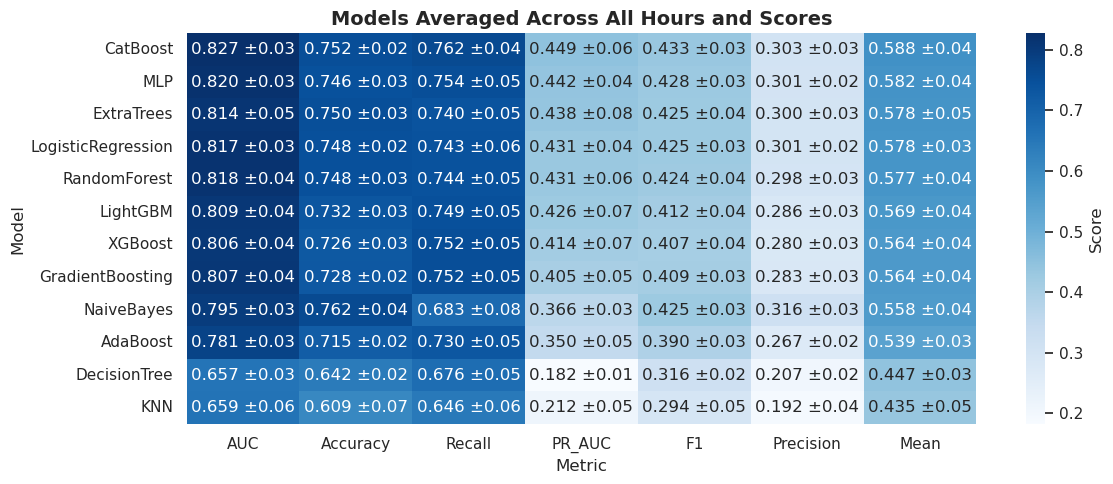

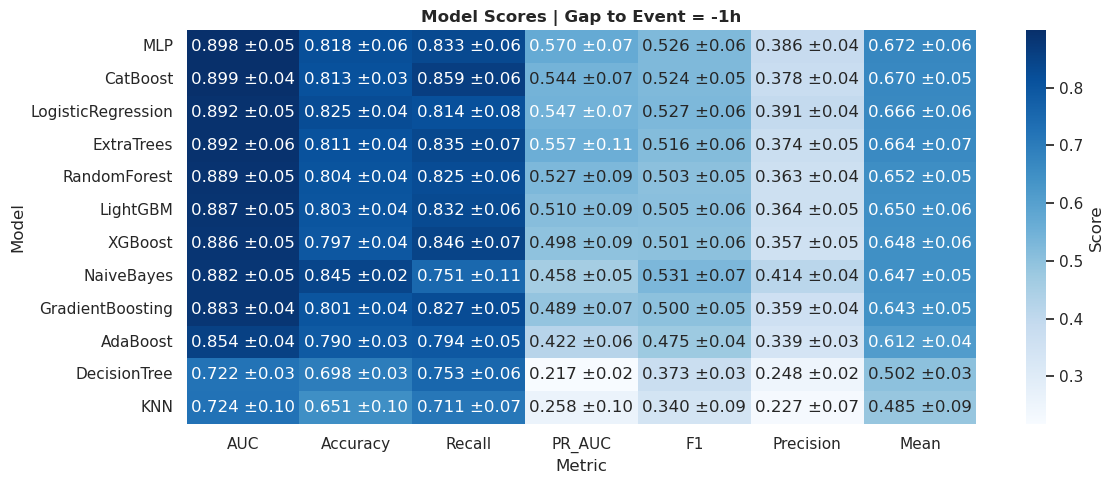

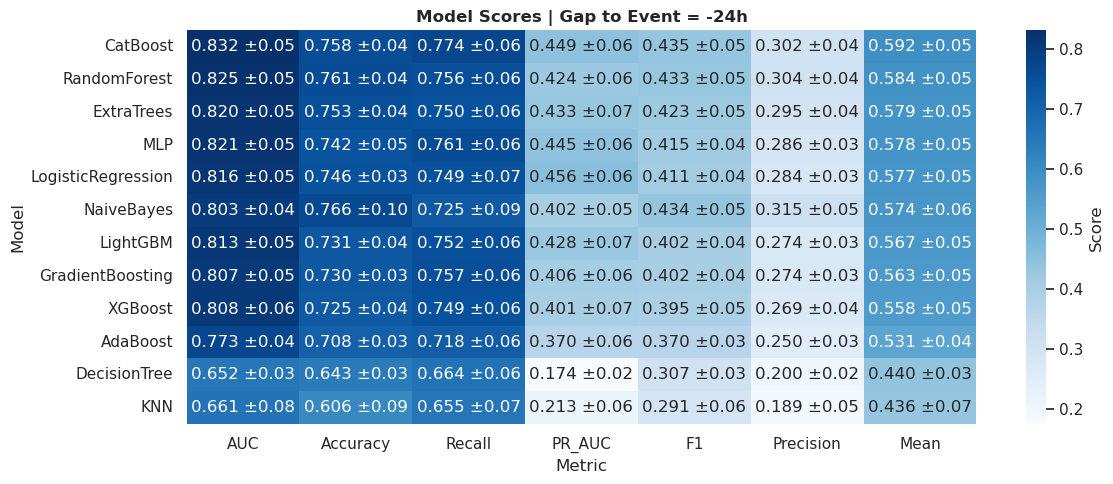

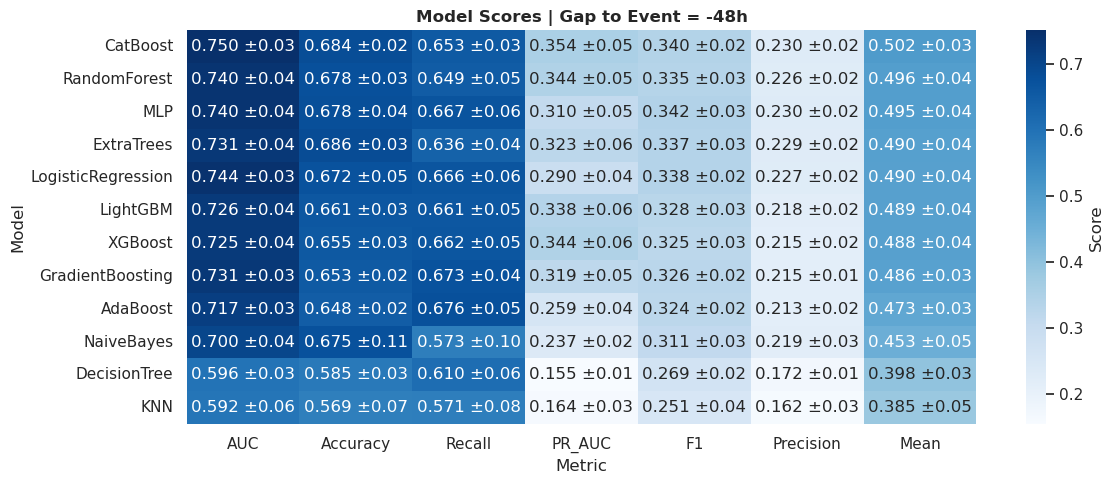

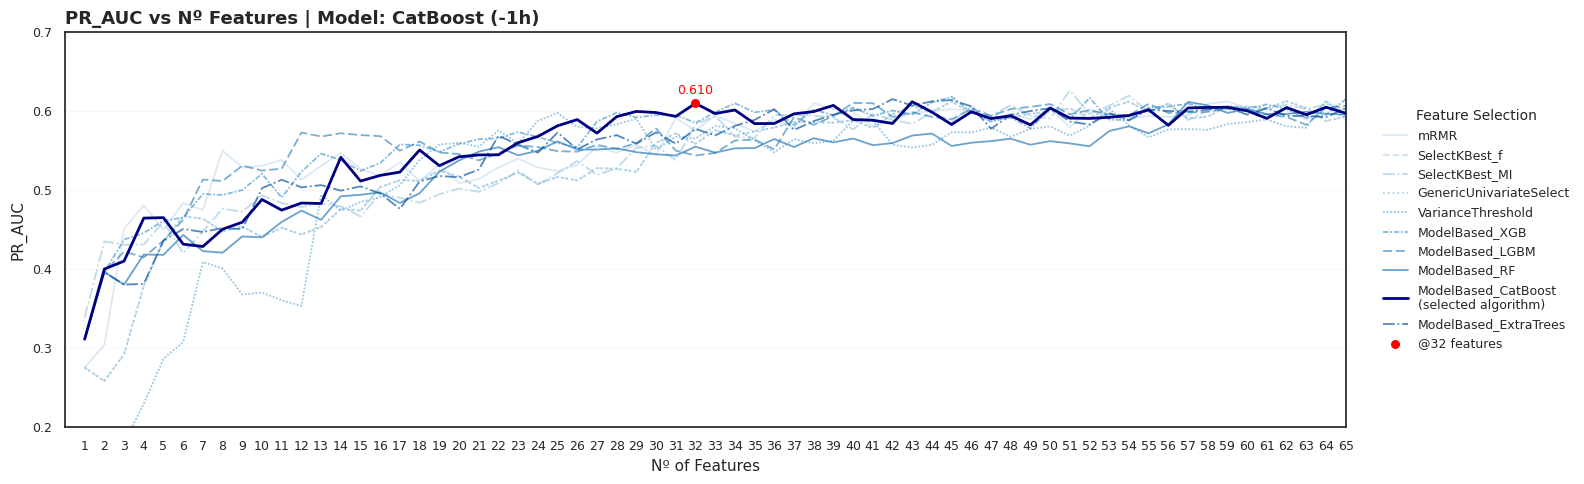

['peep_max', 'temperatura_max', 'fio2_max', 'fr_min', 'pcr_max', 'pcr_median', 'peep_median', 'diuresis_sum', 'aspecto_secreciones_purulentas', 'vt_max', 'pcr_min', 'n_aspiraciones_sum', 'temperatura_median', 'pafi_median', 'spo2_min', 'fr_median', 'pr_peak_median', 'fio2_median', 'fc_median', 'pam_median', 'linfocitos_min', 'peso', 'pafi_max', 'fio2_min', 'creatinina_min', 'creatinina_median', 'pafi_min', 'spo2_median', 'pr_peak_min', 'linfocitos_median', 'creatinina_max', 'fr_max']
Nº features:  32
Nº unique variables:  17
Unique variables:  ['aspecto' 'creatinina' 'diuresis' 'fc' 'fio2' 'fr' 'linfocitos' 'n'
 'pafi' 'pam' 'pcr' 'peep' 'peso' 'pr' 'spo2' 'temperatura' 'vt']


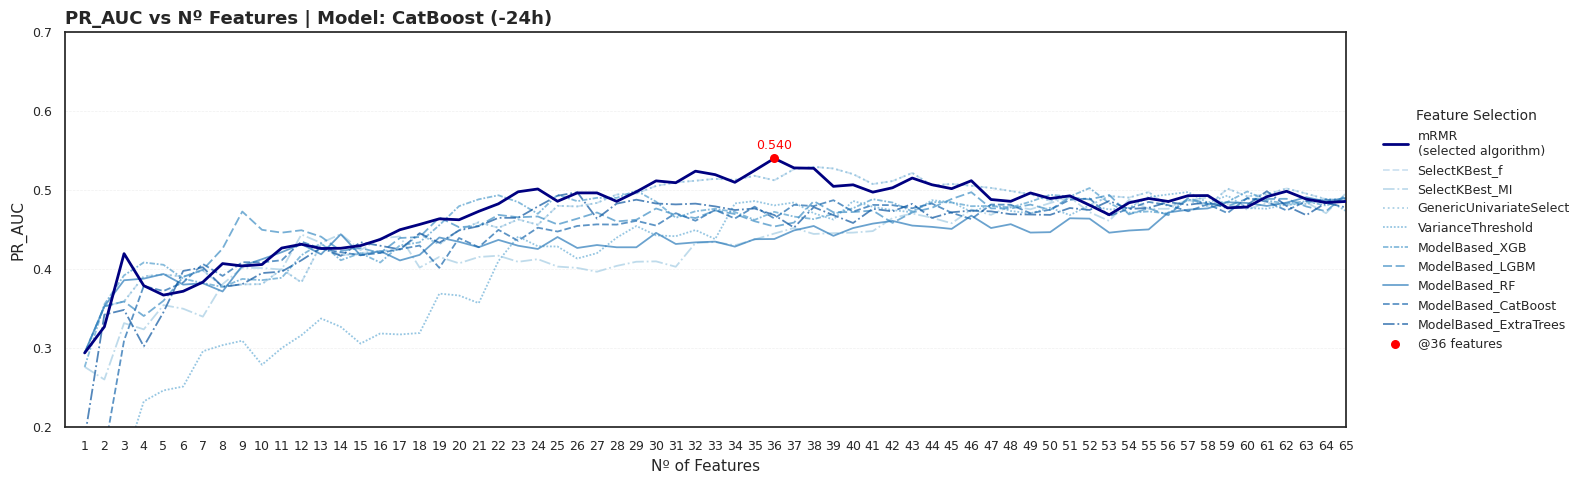

['peep_max', 'Age', 'pcr_median', 'antibioticos', 'temperatura_max', 'fio2_max', 'fr_min', 'fio2_median', 'pcr_min', 'peep_median', 'aspecto_secreciones_purulentas', 'spo2_median', 'pr_plateau_min', 'pcr_max', 'temperatura_median', 'fio2_min', 'pafi_min', 'linfocitos_min', 'pr_plateau_median', 'pr_peak_median', 'fr_median', 'pam_min', 'noradrenalina_sum', 'linfocitos_median', 'pafi_median', 'linfocitos_max', 'pr_peak_max', 'peep_min', 'pam_median', 'pr_peak_min', 'pafi_max', 'leucocitos_min', 'PatType_surgical', 'leucocitos_max', 'leucocitos_median', 'traqueo']
Nº features:  36
Nº unique variables:  17
Unique variables:  ['Age' 'PatType' 'antibioticos' 'aspecto' 'fio2' 'fr' 'leucocitos'
 'linfocitos' 'noradrenalina' 'pafi' 'pam' 'pcr' 'peep' 'pr' 'spo2'
 'temperatura' 'traqueo']


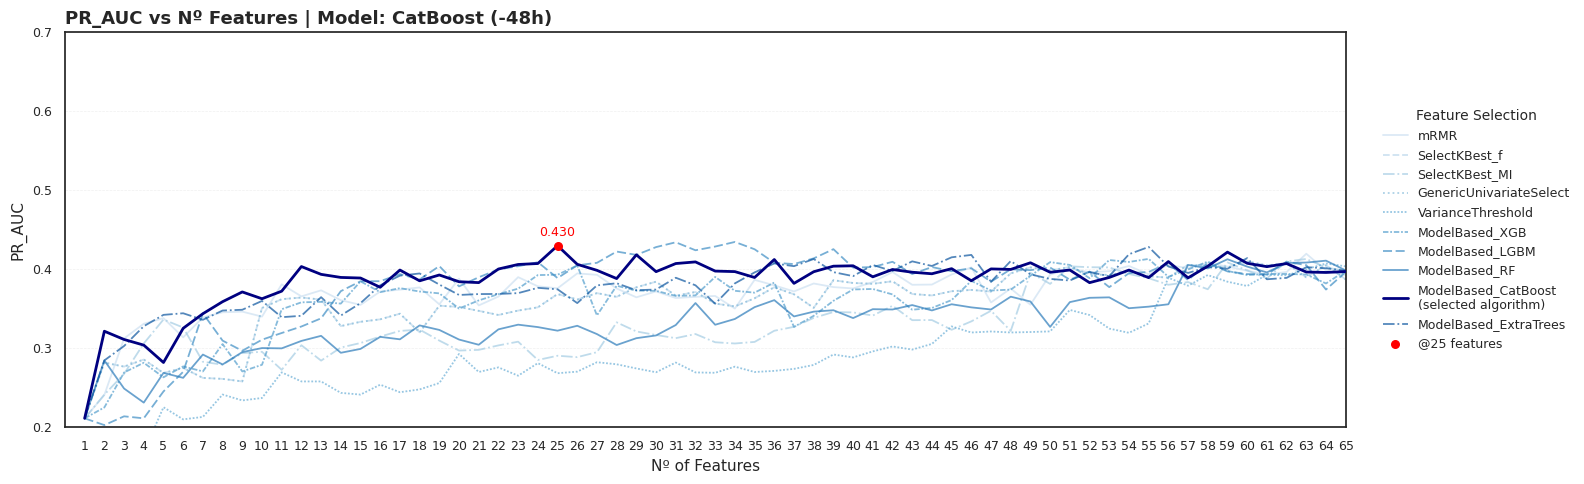

['fio2_median', 'antibioticos', 'fr_median', 'fr_min', 'noradrenalina_sum', 'peep_median', 'fc_max', 'sofa_median', 'linfocitos_median', 'pafi_min', 'peep_max', 'pam_max', 'pafi_max', 'n_aspiraciones_sum', 'linfocitos_min', 'pcr_median', 'spo2_min', 'fio2_max', 'pr_plateau_median', 'pcr_min', 'pr_plateau_max', 'linfocitos_max', 'creatinina_median', 'fr_max', 'diuresis_sum']
Nº features:  25
Nº unique variables:  16
Unique variables:  ['antibioticos' 'creatinina' 'diuresis' 'fc' 'fio2' 'fr' 'linfocitos' 'n'
 'noradrenalina' 'pafi' 'pam' 'pcr' 'peep' 'pr' 'sofa' 'spo2']


In [37]:
top=len(lista_features)
heatmap_global = resumen_modelos_globales(results_all_hrs, metricas=['AUC', 'Accuracy', 'Recall', 'PR_AUC', 'F1', 'Precision'], top=top)
heatmap_por_hr = heatmaps_por_hr(results_all_hrs, metricas=['AUC', 'Accuracy', 'Recall', 'PR_AUC', 'F1', 'Precision'], top=top)
# analizar_resultados_metricas(results_all_hrs, metricas=['AUC', 'Accuracy', 'Recall', 'Precision', 'F1'], top=top)

top_features = graficar_auc_vs_features(
    results=results_1h,
    hr="hr=-1",
    score="PR_AUC",
    max_features=65,
    best_model="CatBoost",
    best_method="ModelBased_CatBoost",
    highlight_point=32,
    ranked_features=ranked_features,
    y_lim_low=.2,
    y_lim_high=.7
)

print(top_features)
print("Nº features: ", len(top_features))
unique_vars = np.unique([feat.split("_")[0] if "_" in feat else feat for feat in top_features])
print("Nº unique variables: ", len(unique_vars))
print("Unique variables: ", unique_vars)

top_features = graficar_auc_vs_features(
    results=results_24h,
    hr="hr=-24",
    score="PR_AUC",
    max_features=65,
    best_model="CatBoost",
    best_method="mRMR",
    highlight_point=36,
    ranked_features=ranked_features,
    y_lim_low=.2,
    y_lim_high=.7
)

print(top_features)
print("Nº features: ", len(top_features))
unique_vars = np.unique([feat.split("_")[0] if "_" in feat else feat for feat in top_features])
print("Nº unique variables: ", len(unique_vars))
print("Unique variables: ", unique_vars)

top_features = graficar_auc_vs_features(
    results=results_48h,
    hr="hr=-48",
    score="PR_AUC",
    max_features=65,
    best_model="CatBoost",
    best_method="ModelBased_CatBoost",
    highlight_point=25,
    ranked_features=ranked_features,
    y_lim_low=.2,
    y_lim_high=.7
)

print(top_features)
print("Nº features: ", len(top_features))
unique_vars = np.unique([feat.split("_")[0] if "_" in feat else feat for feat in top_features])
print("Nº unique variables: ", len(unique_vars))
print("Unique variables: ", unique_vars)